# Perros y Gatos con Convnets en Keras

Basado en el capítulo 5 del libro "Deep Learning with Python" de Francois Chollet, 2018 Manning

Se va a utilizar el dataset de la competencia de Kaggle de clasificación de imágnes de perros y gatos, que consiste en 25000 imágenes RGB de mediana resolución, con diferentes tamaños, equilibradamente distribuidas en las dos clases.

## Obtención y preparación del dataset

Vamos a separar las imágenes en 2000 para entrenamiento, 1000 para validación del entrenamiento y 1000 para test

In [1]:
import os, shutil

Primero vamos a verificar que las imágenes están en el directorio especificado

In [2]:
# El directorio con los datos originales bajados de Kaggle
original_dataset_dir = "/home/icesi/Dropbox/Cursos_Propios/MIT - Deep Learning/05 - CNNs/cats_and_dogs/datos_originales"

# El directorio con los particionamientos que utilizaremos para entrenar, validar y evaluar
base_dir = '/home/icesi/Dropbox/Cursos_Propios/MIT - Deep Learning/05 - CNNs/cats_and_dogs/'

os.listdir(original_dataset_dir)[0:10]

['dog.1640.jpg',
 'cat.7078.jpg',
 'dog.7997.jpg',
 'dog.5585.jpg',
 'cat.4570.jpg',
 'dog.11745.jpg',
 'cat.864.jpg',
 'dog.6230.jpg',
 'dog.3857.jpg',
 'cat.6911.jpg']

Ahora vamos a crear una estructura de directorios (train, validation, test), cada uno con dos subdirectorios (cats, dogs)

## Lo que sigue solo se debe correr si no se tienen aún los datasets particionados

In [4]:
# Directorios de entrenamiento, validación y test
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [3]:
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

# Subdirectorios de entrenamiento con fotos de perros y gatos
os.mkdir(train_cats_dir)
os.mkdir(train_dogs_dir)

# Subdirectorios de validación con fotos de perros y gatos
os.mkdir(validation_cats_dir)
os.mkdir(validation_dogs_dir)

# Subdirectorios de test con fotos de perros y gatos
os.mkdir(test_cats_dir)
os.mkdir(test_dogs_dir)

Ahora copiamos las imágenes del dataset en los directorios correspondientes al particionamiento. Utilizamos el protocolo de los nombres dados a los archivos que nos permite identificar las que son de clase gato y las que son de clase perro.

Vamos a tener 2000 imágenes de entrenamiento, 1000 de validación y 1000 de test. Los datasets van a estar perfectamente balanceados.

In [5]:
# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Verificamos que la cantidad de archivos sea la indicada

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## Definición del modelo

Vamos a definir un modelo:
* que recibe un tensor con las instancias de imágen con tres ejes con la dimensionalidad (150, 150, 3), 
* con 4 capas convolucionales 2D, todas con filtros 3x3 y función de activación RELU; la primera con 32 filtros, la segunda con 64 filtros, y la tercera y cuarta con 128 filtros.
* con 3 capas intermedias de MAX pooling que toman las salidas de las capas convolucionales.
* con una capa Flatten que permite cambiar la representación de las salidas de las capas convolucionales a un tensor de un solo eje
* con dos capas Dense, fully connected, la primera con 512 neuronas y RELU, la segunda, la capa de salida, con 1 sola neurona que utiliza una función sigmoide para clasificar las instancias en dos clases (binarias).
* una capa de dropout entre las capas densas con probabilidad de 30%.

In [6]:
import keras

Using TensorFlow backend.


In [7]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Tenemos en total mas de 3.4 millones de parámetros!

Ahora compilamos el modelo con un **rmsprop**, y una función de perdida de **binary_crossentropy**.

In [9]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Preprocesamiento de datos a partir de generadores

Como es debido, necesitamos adaptar el formato de las imágenes para que estén aptas para ser entradas a la red neuronal.
Pero no vamos a hacerlo a mano.

Vamos a utilizar los **ImageGenerators** de Keras, del tipo generator de Python que trabajan como iteradores, permitiendo hacer preprocesamiento de datos dentro de ciclos. En este caso, nos permiten:
* decodificar el formato RGB, convirtiendo las imágenes a una representación adecuada (es el propósito de base del ImageGenerator)
* normalizar las imágenes y cambiarles el tipo de datos a punto flotante (esto se hace al instanciar el generador)
* modificar el tamaño, para que todas tengan 150 x 150 (esto se hace al leer y procesar cada imágen por demanda)

También, los generadores permiten tratar las imágenes por batch, de tal manera que a cada petición de generación se puede obtener una muestra de varias imágenes de un tamaño de batch especifico.
Además, la función de flujo de imágenes por el generador desde un directorio definido es capaz de determinar la clase de las imágenes dados los nombres de los subdirectorios encontrados en la ruta especificada, sean estas binarias o múltiples.

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# Convertimos las imágenes a punto flotante, reescalando los valores a valores entre 0 y 1
# Estos generadores de imágenes van a permitir convertir los datos de archivos de imágen a tensores 

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Se define el flujo de paso por el generador de imágenes desde el directorio de origen de las mismas,
# especificando el tamaño final, el tamaño del batch a leer y el tipo de variable objetivo que se desea.
train_generator = train_datagen.flow_from_directory(
        train_dir,              # Directorio de origen
        target_size=(150, 150), # Todas las imágenes quedarán de 150x150 pixeles
        batch_size=20,          # Se van a leer y pre procesar batches de a 20 imágenes
        class_mode='binary')    # Como usamos una función de perdida binaria, la clase debe ser binaria

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


El iterador de los generadores va a devolver los tensores con los batches de entrada y con las etiquetas de salida correspondientes.
Para entender mejor los generadores, veamos como uno de ellos nos permite obtener tanto los tensores como las clases correspondientes de las imágenes procesadas: 

In [12]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [13]:
labels_batch

array([1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 0., 0.], dtype=float32)

Un llamado al generador de entrenamiento nos retorna dos valores: un tensor de 20 imágenes de 150x150x3 (RGB), y 20 labels con sus clases correspondientes.

## Entrenamiento del modelo

Vamos a entrenar el modelo a partir de los datos producidos por los generadores, que proporcionarán los datos de entrenamiento y de validación de monitoría de la calidad del aprendizaje a lo largo de 30 épocas de entrenamiento.
En vez de llamar a la función **fit** del modelo, que utilizaríamos si tuvieramos los tensores de los datos de entrada y validación ya listos, vamos a llamar a la función **fit_generator**, que realiza el entrenamiento a partir de generadores.

Si bien se comportan como iteradores, los generadores pueden producir datos indefinidamente, sin parar cuando se le da una vuelta a la fuente de datos original. Para especificar el largo de una época en términos de los generadores, se necesita definir cuantas invocaciones a los generadores equivalen una época, este el propósito del parámetro *steps_per_epoch* (para el generador de entrenamiento) y de *validation_steps* para el generador de validación. Como se tienen 2000 imágenes de entrenamiento, y se están generando batchs de a 20, con 100 pasos se le daría la vuelta al dataset completo; para el set de 1000 imágenes de validación, con batchs de a 20, con 50 pasos se usarían todas las imágenes.

In [14]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 15s 151ms/step - loss: 0.6935 - acc: 0.5205 - val_loss: 0.6827 - val_acc: 0.5010
Epoch 2/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6676 - acc: 0.5865 - val_loss: 0.6601 - val_acc: 0.5910
Epoch 3/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6329 - acc: 0.6490 - val_loss: 0.6528 - val_acc: 0.5950
Epoch 4/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5955 - acc: 0.6845 - val_loss: 0.5970 - val_acc: 0.6880
Epoch 5/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5538 - acc: 0.7080 - val_loss: 0.6657 - val_acc: 0.6310
Epoch 6/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5300 - acc: 0.7280 - val_loss: 0.5779 - val_acc: 0.6910
Epoch 7/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5024 - acc: 0.7535 - val_loss: 0.6046 - val_acc: 0.6840
Epoch 8/30
100/100 [==============================] - 5s 50ms/step 

Es siempre una buena idea grabar el modelo una vez entrenado, así se puede volver a usar sin tener que pasar por todo el proceso de entrenamiento, que puede ser bastante largo. En una máquina sin GPU, esto dura un poco mas de 1 hora.

Con 2 GPU GTX 1080Ti se demora 3 minutos.

In [17]:
model_path = base_dir + "cats_and_dogs_small_1.h5"
print(model_path)
model.save(model_path)

/home/icesi/Dropbox/Cursos_Propios/MIT - Deep Learning/05 - CNNs/cats_and_dogs/cats_and_dogs_small_1.h5


Lo que se está grabando en el archivo es los pesos asociados a cada capa, mas no la estructura del modelo; los pesos van a esperar que el modelo al que se estan cargando coincida con la estructura original. Para poder cargarlos de nuevo a un modelo vació, es necesario crear la estructura del modelo completamente y luego si cargar el archivo:

In [18]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.load_weights(model_path)

## Evaluación de los resultados del modelo

Vamos a analizar la evaluación del rendimiento del modelo durante las épocas de aprendizaje

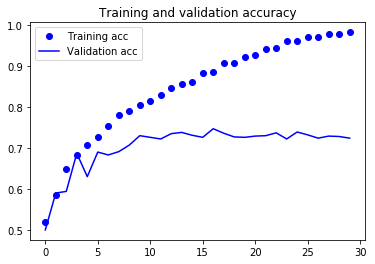

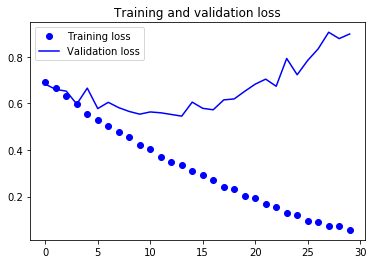

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Podemos ver que el loss de entrenamiento esta continuamente reduciendose (hasta llegar casi a 0) y la exactitud de entrenamiento esta continuamente creciendo (hasta llegar al 100%) a medida que pasan las épocas, pero con el set de validación esto no ocurre.
El mínimo loss de validación se alcanza entre la época 6 y 10 para luego comenzar a decrecer, y la mayor exactitud (entre 70-72%) que luego no puede seguir mejorando. Estamos frente a un caso de **overfitting**.

Como tenemos tan solo 2000 imágenes de entrenamiento (muy pocas para una tarea de la complejidad de la tratada), es díficil de evitar el overfitting.

La mejor manera de combatir el overfitting es obteniendo un dataset de aprendizaje mayor. Como no tenemos una manera real de hacerlo, vamos a generar sintéticamente mas datos, algo que se puede hacer el caso de imágenes con una técnica llamada **data augmentation**.

## Data augmentation

Para mitigar el problema de overfitting en el caso de datasets con pocas imágenes, se pueden crear nuevas imágenes aplicando transformaciones gráficas a las imágenes disponibles, "aumentando" así el dataset de entrenamiento de manera artificial.

En Keras, esto se hace con la clase `ImageDataGenerator`. 

In [21]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Las transformaciones de imágenes posibles son:
* `rotation_range`: el ángulo máximo de rotación a aplicar a la imágen (0-180), dentro del cuál se tomará un ángulo al azar.
* `width_shift` y `height_shift`: la fracción del ancho o largo de traslación máximo que define el rango de traslación vertical u horizontal (0.0-1.0) del cual se tomará un valor al azar.
* `shear_range`: define el nivel de distorción máxima por estiramiento de la imágen transformada que se desea (0.0-1.0), escogido aleatoriamente.
* `zoom_range`: el nivel de aceramiento máximo de la imágen que se desea (0.0-1.0), el valor es escogido aleatoriamente.
* `horizontal_flip`: especifica si se desea que sea posible aplicar un espejo de la imágen horizontal a la mitad de las imágenes (aleatoriamente).
* `vertical_flip`: especifica si se desea que sea posible aplicar un espejo de la imágen vertical a la mitad de las imágenes (aleatoriamente). Esto no aplica para todas las imágenes, pues puede que nunca se traten imágenes reales "patas arriba".
* `fill_mode`: indica cómo se generan nuevos pixeles que puedan aparecer despues de una tranformación (rotación, traslación).

Hay muchas más opciones de transformaciones, es necesario consultar la documentación de Keras.]

Podemos ver cómo quedan las imágenes transforamadas:

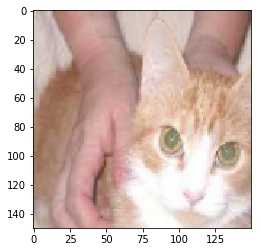

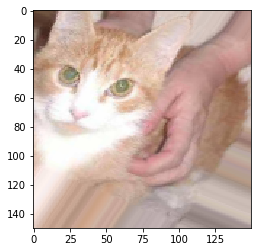

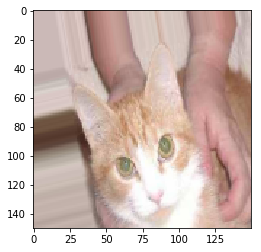

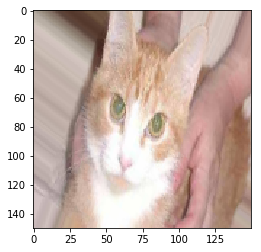

In [22]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1): #esta línea jamás llega a un fin, por lo que es necesario hacer el break
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

Podemos ver cómo de una sola imágen se pueden generar una infinidad, pero todas van a estar correlacionadas entre ellas y no vamos a poder producir real nueva información, por lo que si bien el **data augmentation** permite reducir (mitigar) el overfitting, esta lejos de poder eliminarlo. Por eso vamos a combinar esta estrategía con la de **dropout** antes de las capas densas.

## Entrenamiento de modelo con data augmentation

Vamos a redefinir el modelo y reentrenarlo utilizando los data generators con data augmentation. El dataset de validación no debe pasar por el proceso de data augmentation.

Al haber agregado técnicas de para reducir el **overfitting**, también vamos a aumentar el número de epocas de entrenamiento a 100 para asegurarnos de que podamos encontrar el óptimo y que no nos quedemos ahora en una situación de **underfitting**.

El proceso de aprendizaje en una máquina normal dura alrededor de 4 horas y media.

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # La capa adicional de regularización agregada
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 17s 171ms/step - loss: 0.6927 - acc: 0.5200 - val_loss: 0.6810 - val_acc: 0.5250
Epoch 2/100
100/100 [==============================] - 16s 158ms/step - loss: 0.6779 - acc: 0.5731 - val_loss: 0.6715 - val_acc: 0.5590
Epoch 3/100
100/100 [==============================] - 16s 159ms/step - loss: 0.6636 - acc: 0.5891 - val_loss: 0.6492 - val_acc: 0.6040
Epoch 4/100
100/100 [==============================] - 16s 158ms/step - loss: 0.6492 - acc: 0.6094 - val_loss: 0.6341 - val_acc: 0.6140
Epoch 5/100
100/100 [==============================] - 16s 157ms/step - loss: 0.6319 - acc: 0.6344 - val_loss: 0.6067 - val_acc: 0.6610
Epoch 6/100
100/100 [==============================] - 19s 194ms/step - loss: 0.6122 - acc: 0.6594 - val_loss: 0.6023 - val_acc: 0.6630
Epoch 7/100
100/100 [==============================] - 16s 157ms/step - loss: 0.6078 - acc: 0.6578 -

In [25]:
model_path = base_dir + "cats_and_dogs_small_2_dataaug.h5"
print(model_path)
model.save(model_path)

/home/icesi/Dropbox/Cursos_Propios/MIT - Deep Learning/05 - CNNs/cats_and_dogs/cats_and_dogs_small_2_dataaug.h5


En un CPU, esto se demora 4 horas y media.

En 2 GPUs GTX 1030Ti se demora 26 minutos.

## Evaluación del modelo con data augmentation

Veamos cómo le fue al modelo con data augmentation.

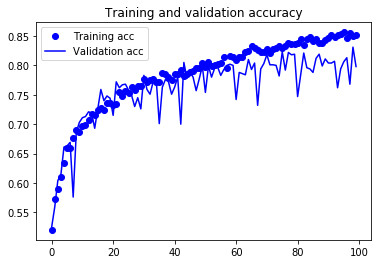

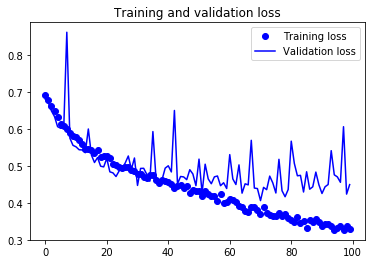

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Gracias a las técnicas de prevención del overfitting, las curvas de entrenamiento y validación son bastante cercanas, llegando a una exactitud del 82%, bien superior al 70-72% que se obtenía sin los métodos de regularización.

Yendo más lejos, modificando la arquitectura del modelo y parámetros de optimización, se puede obtenre hasta un 86-87% de exactitud, pero este límite no se podría sobrepasar, dado que el tamaño de datos reales es muy pequeño y el **data augmentation** no puede crear nueva información de la nada.

Un siguiente paso a tomar sería no entrenar una Convnet desde cero, hay muy poca información para ello, sino utilizar un modelo pre entrenado, adaptarlo y reentrenarlo para la nueva tarea en cuestión. 